In [1]:
# Vincent F. Scalfani
# Ideas/TODO
# [ ] - Figure out how to shrink the print area to get molecules smaller without distorting them too much
# [ ] - Add color to atom symbols and maybe make print text bold
# [ ] - Experiment with different symbols for bonds (e.g. single (-), double (=), triple (#), aromatic (:)

In [2]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdCoordGen
from rdkit import Geometry
from PIL import Image
from io import BytesIO
import numpy as np

In [3]:
def draw_mol_coordgen(mol):   
    #1. Draw mol with rdCoordGen
    rdCoordGen.AddCoords(mol)
    drawer = rdMolDraw2D.MolDraw2DCairo(400,400)
    drawer.drawOptions().fixedBondLength = 40
    drawer.DrawMolecule(mol)
    drawer.FinishDrawing()
    bio = BytesIO(drawer.GetDrawingText())
    Img = Image.open(bio)
    return Img

In [4]:
def print_mol_ascii(mol):   
    #1. Draw mol with rdCoordGen
    rdCoordGen.AddCoords(mol)
    drawer = rdMolDraw2D.MolDraw2DCairo(300,300)
    drawer.drawOptions().fixedBondLength = 40
    drawer.DrawMolecule(mol)
    drawer.FinishDrawing()
    
    #2. Get atom x,y coordinates
    # adapated from: https://gist.github.com/greglandrum/0c8b80825826392a6519af7519862baf
    atom_index = []
    atom_symbols = []
    atom_xpos = []
    atom_ypos = []
    conf = mol.GetConformer()
    for i in range(mol.GetNumAtoms()):
        atom_index.append(i)
        atom_symbols.append(mol.GetAtomWithIdx(i).GetSymbol())
        pos_A = conf.GetAtomPosition(i)
        pos_point = Geometry.Point2D(pos_A.x,pos_A.y)
        dpos = drawer.GetDrawCoords(pos_point)      
        atom_xpos.append(dpos.x)
        atom_ypos.append(dpos.y)
    
    #3. Resize and shift coordinates   
    atom_coords = list(zip(atom_xpos, atom_ypos))
    # A scale between 1/12 and 1/20 seems to work okay without distorting printing aspect ratio
    scale_atom_coords = [(p[0]/14, p[1]/14) for p in atom_coords]
    round_atom_coords = [(round(p[0]), round(p[1])) for p in scale_atom_coords]
    # Get min and max for x,y
    xmin = min(c[0] for c in round_atom_coords)
    xmax = max(c[0] for c in round_atom_coords)
    ymin = min(c[1] for c in round_atom_coords)
    ymax = max(c[1] for c in round_atom_coords)
    # figure out what to substract to shift coordinates by a min
    if xmin < ymin:
        xymin = xmin
    else:
        xymin = ymin
    # shift by xymin to move mol closer to origin
    norm_atom_coords = [(p[0] - xymin, p[1] - xymin) for p in round_atom_coords]
    
    #4. Get Bond connection information for drawing bonds
    atom_begin = []
    atom_end = []
    bond_type = []

    for bond in mol.GetBonds():
        atom_begin.append(bond.GetBeginAtomIdx())
        atom_end.append(bond.GetEndAtomIdx())
        bond_type.append(bond.GetBondTypeAsDouble()) # this could be used to define single, double, arom with symbols
    
    #5. Get coordinates of middle of bond for plotting
    
    begin_connection_xpos = []
    begin_connection_ypos = []
    for i in atom_begin:
        begin_connection_xpos.append(norm_atom_coords[i][0])
        begin_connection_ypos.append(norm_atom_coords[i][1])
        
    end_connection_xpos = []
    end_connection_ypos = []
    for i in atom_end:
        end_connection_xpos.append(norm_atom_coords[i][0])
        end_connection_ypos.append(norm_atom_coords[i][1])
    
    midx_bond = []
    for x1,x2 in zip(begin_connection_xpos, end_connection_xpos):
        middle = (x1+x2)/2
        midx_bond.append(middle)

    midy_bond = []
    for y1,y2 in zip(begin_connection_ypos, end_connection_ypos):
        middle = (y1+y2)/2
        midy_bond.append(middle)
    # xy coordinates of center of bonds (*) to plot
    bond_center_points = list(zip(midx_bond,midy_bond))
    
    #6. Setup a max plotting print range based on coordinates
    
    if xmax > ymax:
        xymax = xmax
    else:
        xymax = ymax
    # this just gets the steps for x.y coordinates in increments of 0.5 for the print grid
    start = 0
    stop = round(xymax+1)
    samples = round((stop*2)+1)
    print_range = np.linspace(start,stop,samples)
    
    #7. Print the molecule!
    # Adapted from: https://stackoverflow.com/questions/16240358/ascii-graph-in-python // https://creativecommons.org/licenses/by-sa/3.0/
    bond_symbol = '*'
    fill_symbol = ' '
    for y in print_range:
        chars = []
        for x in print_range:
            if (x,y) in norm_atom_coords:
                index_value = norm_atom_coords.index((x,y))
                chars.append(atom_symbols[index_value])
            elif (x,y) in bond_center_points:
                chars.append(bond_symbol)    
            else:
                chars.append(fill_symbol)
        print(' '.join(chars))

In [5]:
# Testing with some examples from here: 
# https://github.com/rdkit/UGM_2020/blob/master/Notebooks/Landrum_WhatsNew.ipynb

m1 = Chem.MolFromSmiles('c1c[nH]cc1C(F)(F)F')
doravirine = Chem.MolFromSmiles('Cn1c(n[nH]c1=O)Cn2ccc(c(c2=O)Oc3cc(cc(c3)Cl)C#N)C(F)(F)F')
cyclosporine = Chem.MolFromSmiles('C/C=C/CC(C)C(O)C1C(=O)NC(CC)C(=O)N(C)CC(=O)N(C)C(CC(C)C)C(=O)NC(C(C)C)C(=O)N(C)C(CC(C)C)C(=O)NC(C)C(=O)NC(C)C(=O)N(C)C(CC(C)C)C(=O)N(C)C(CC(C)C)C(=O)N(C)C(C(C)C)C(=O)N1C')

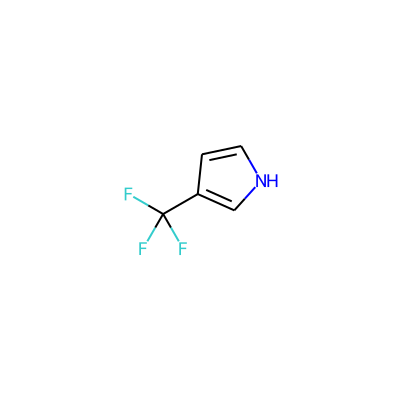

In [6]:
draw_mol_coordgen(m1)

In [7]:
print_mol_ascii(m1)

                                                                 
                                                                 
                                                                 
                                                                 
                        C     *     C                            
                                                                 
                                      *                          
                      *                                          
                                        N                        
                                                                 
F                   C               *                            
                          *                                      
      *         *               C                                
                                                                 
            C                                                    
          

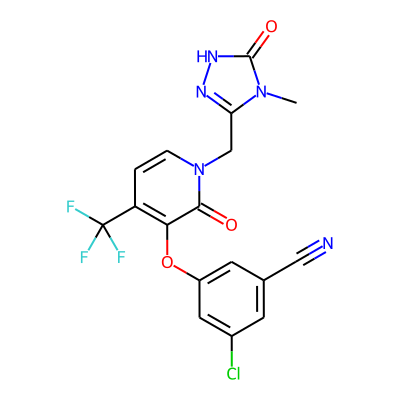

In [8]:
draw_mol_coordgen(doravirine)

In [9]:
print_mol_ascii(doravirine)

                                                        O                            
                                                                                     
                                                    *                                
                                                                                     
                                        N   *   C                                    
                                                                                     
                                        *         *                                  
                                                                                     
                                        N           N                                
                                          *     *       *                            
                                            C               C                        
                                                      

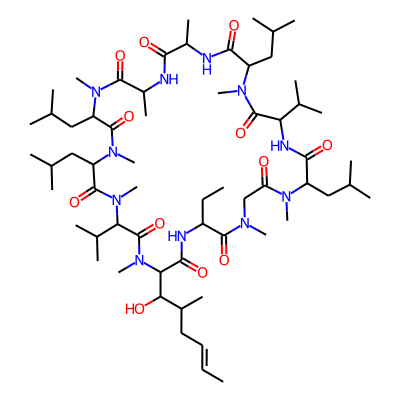

In [10]:
draw_mol_coordgen(cyclosporine)

In [11]:
print_mol_ascii(cyclosporine)

                                    C           O   C       C                        
                                    *                 *   *                          
                            O       C         *         C                            
                              *   *   *                 *                            
                    O           C       N * C           C                            
                    *           *             *     *                                
            C       C           N               C           C                        
              *   *     *     *                 *                                    
        C       N           C               C * N           *                        
        *       *           *                     *                                  
        C       C       O   C                       C * C * C * C                    
      *   *   *   *   *                           *   

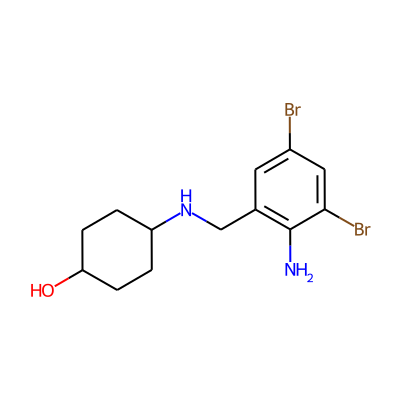

In [12]:
m2 = Chem.MolFromSmiles('C1CC(CCC1NCC2=C(C(=CC(=C2)Br)Br)N)O')
draw_mol_coordgen(m2)


In [13]:
print_mol_ascii(m2)

                                                                                     
                                                                                     
                                                                                     
                                                                                     
                                                                                     
                                                                                     
                                                                                     
                                                                                     
                                                        Br                            
                                                                                     
                                                        *                            
                                                     